In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from jax_nn import create_mlp, fit, binary_crossentropy_loss, mse_loss
from jax import random
from jax.experimental.stax import Relu, Sigmoid, Softmax

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

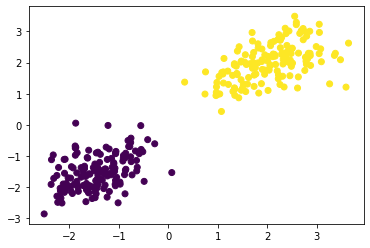

In [3]:
c_means = [[-1.5, -1.5], [2.0, 2.0]]
c_var = 0.30**2
x_var = 1e-2

np.random.seed(0)
indices = np.random.randint(2, size=300)
samples = [
    np.random.multivariate_normal(c_means[i], c_var * np.eye(2) + 0.2 * np.ones((2, 2))) + 
           np.random.multivariate_normal(np.zeros(2), x_var**0.5 * np.eye(2)) 
           for i in indices]

x_train = np.array(samples)
plt.scatter(x_train[:, 0], x_train[:, 1], c=indices)
plt.show()

## Classification

In [4]:
data = (x_train, indices.reshape(-1, 1))
rng_key = random.PRNGKey(0)
# We're not batching anything, so shapes of inputs and outputs are just shapes of data
input_dim = 2
output_dim = 1
hidden_widths = [6]
init_model, predict = create_mlp(hidden_widths, Relu, output_dim, Sigmoid)
output_shape, start_params = init_model(rng_key, (-1, input_dim))
model = (predict, binary_crossentropy_loss)
fit_params, history = fit(model, start_params, data, step_size=1e-2, max_iter=200)

In [5]:
history = pd.DataFrame(history, columns=['loss', 'grad_norm'], dtype='float32')
history

,loss,grad_norm
0,0.685108,0.689037
1,0.646065,0.644802
2,0.608912,0.601674
3,0.573524,0.561199
4,0.539805,0.523525
...,...,...
195,0.003322,0.006657
196,0.003295,0.006605
197,0.003268,0.006554
198,0.003242,0.006504


<AxesSubplot:>

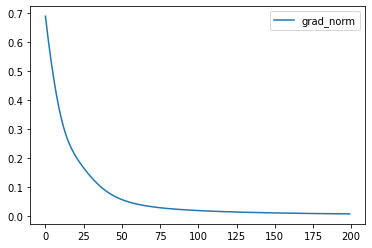

In [6]:
history.plot.line(y='grad_norm')

<AxesSubplot:>

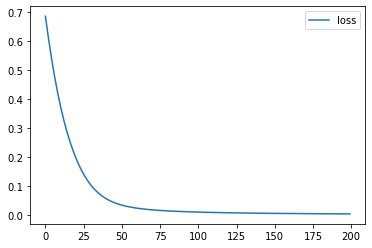

In [7]:
history.plot.line(y='loss')

In [8]:
class_df = pd.DataFrame({'true': indices == 1, 'pred': predict(fit_params, x_train)[:,0] > 0.5})
class_df

,true,pred
0,False,False
1,True,True
2,True,True
3,False,False
4,True,True
...,...,...
295,False,False
296,False,False
297,False,False
298,True,True


In [9]:
(class_df['true'] == class_df['pred']).mean()

1.0

## Regression

In [10]:
data = (x_train, x_train)
rng_key = random.PRNGKey(0)
# We're not batching anything, so shapes of inputs and outputs are just shapes of data
input_dim = 2
output_dim = 2
hidden_widths = [100]
init_model, predict = create_mlp(hidden_widths, Relu, output_dim)
output_shape, start_params = init_model(rng_key, (-1, input_dim))
model = (predict, mse_loss)
fit_params, history = fit(model, start_params, data, step_size=1e-1, max_iter=200)

In [11]:
history = pd.DataFrame(history, columns=['loss', 'grad_norm'], dtype='float32')
history

,loss,grad_norm
0,3.183546,3.768245
1,4.161569,6.616199
2,0.188818,1.059701
3,2.245172,3.217655
4,0.970969,1.580503
...,...,...
195,0.000054,0.000123
196,0.000054,0.000119
197,0.000054,0.000109
198,0.000053,0.000097


<AxesSubplot:>

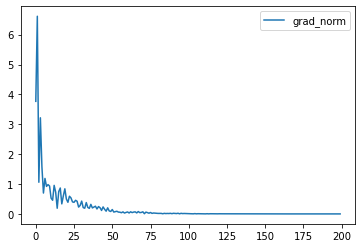

In [12]:
history.plot.line(y='grad_norm')

<AxesSubplot:>

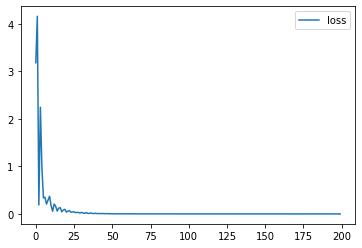

In [13]:
history.plot.line(y='loss')

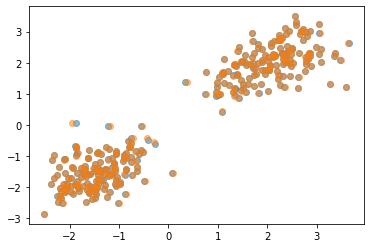

In [14]:
regress_df = pd.DataFrame(x_train).join(pd.DataFrame(predict(fit_params, x_train)), lsuffix='_true')
plt.scatter(regress_df['0_true'], regress_df['1_true'], alpha=0.5)
plt.scatter(regress_df['0'], regress_df['1'], alpha=0.5)

In [214]:
%debug

> <ipython-input-188-8b20d831becf>(1)<module>()
----> 1 data = (x_train[:2,:], indices[:2,:])
      2 rng_key = random.PRNGKey(0)
      3 # We're not batching anything, so shapes of inputs and outputs are just shapes of data
      4 input_dim = 2
      5 output_dim = 1



ipdb>  q


In [ ]:
%debug

In [185]:
# Copyright 2018 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""Datasets used in examples."""


import array
import gzip
import os
from os import path
import struct
import urllib.request

import numpy as np


_DATA = "/tmp/jax_example_data/"


def _download(url, filename):
  """Download a url to a file in the JAX data temp directory."""
  if not path.exists(_DATA):
    os.makedirs(_DATA)
  out_file = path.join(_DATA, filename)
  if not path.isfile(out_file):
    urllib.request.urlretrieve(url, out_file)
    print("downloaded {} to {}".format(url, _DATA))


def _partial_flatten(x):
  """Flatten all but the first dimension of an ndarray."""
  return np.reshape(x, (x.shape[0], -1))


def _one_hot(x, k, dtype=np.float32):
  """Create a one-hot encoding of x of size k."""
  return np.array(x[:, None] == np.arange(k), dtype)


def mnist_raw():
  """Download and parse the raw MNIST dataset."""
  # CVDF mirror of http://yann.lecun.com/exdb/mnist/
  base_url = "https://storage.googleapis.com/cvdf-datasets/mnist/"

  def parse_labels(filename):
    with gzip.open(filename, "rb") as fh:
      _ = struct.unpack(">II", fh.read(8))
      return np.array(array.array("B", fh.read()), dtype=np.uint8)

  def parse_images(filename):
    with gzip.open(filename, "rb") as fh:
      _, num_data, rows, cols = struct.unpack(">IIII", fh.read(16))
      return np.array(array.array("B", fh.read()),
                      dtype=np.uint8).reshape(num_data, rows, cols)

  for filename in ["train-images-idx3-ubyte.gz", "train-labels-idx1-ubyte.gz",
                   "t10k-images-idx3-ubyte.gz", "t10k-labels-idx1-ubyte.gz"]:
    _download(base_url + filename, filename)

  train_images = parse_images(path.join(_DATA, "train-images-idx3-ubyte.gz"))
  train_labels = parse_labels(path.join(_DATA, "train-labels-idx1-ubyte.gz"))
  test_images = parse_images(path.join(_DATA, "t10k-images-idx3-ubyte.gz"))
  test_labels = parse_labels(path.join(_DATA, "t10k-labels-idx1-ubyte.gz"))

  return train_images, train_labels, test_images, test_labels


def mnist(permute_train=False):
  """Download, parse and process MNIST data to unit scale and one-hot labels."""
  train_images, train_labels, test_images, test_labels = mnist_raw()

  train_images = _partial_flatten(train_images) / np.float32(255.)
  test_images = _partial_flatten(test_images) / np.float32(255.)
  train_labels = _one_hot(train_labels, 10)
  test_labels = _one_hot(test_labels, 10)

  if permute_train:
    perm = np.random.RandomState(0).permutation(train_images.shape[0])
    train_images = train_images[perm]
    train_labels = train_labels[perm]

  return train_images, train_labels, test_images, test_labels

In [442]:
# Copyright 2018 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""A basic MNIST example using JAX with the mini-libraries stax and optimizers.

The mini-library jax.experimental.stax is for neural network building, and
the mini-library jax.experimental.optimizers is for first-order stochastic
optimization.
"""


import time
import itertools

import numpy.random as npr

import jax.numpy as jnp
from jax import jit, grad, random, value_and_grad
from jax.experimental import optimizers
from jax.experimental import stax
from jax.experimental.stax import Dense, Relu, LogSoftmax

def loss(params, batch):
  inputs, targets = batch
  preds = predict(params, inputs)
  return -jnp.mean(jnp.sum(preds * targets, axis=1))

def accuracy(params, batch):
  inputs, targets = batch
  target_class = jnp.argmax(targets, axis=1)
  predicted_class = jnp.argmax(predict(params, inputs), axis=1)
  return jnp.mean(predicted_class == target_class)

init_random_params, predict = stax.serial(
    Dense(1024), Relu,
    Dense(10), LogSoftmax)

if __name__ == "__main__":
  rng = random.PRNGKey(0)

  step_size = 0.001
  num_epochs = 10
  batch_size = 128
  momentum_mass = 0.9

  train_images, train_labels, test_images, test_labels = mnist()
  num_train = train_images.shape[0]
  num_complete_batches, leftover = divmod(num_train, batch_size)
  num_batches = num_complete_batches + bool(leftover)

  def data_stream():
    rng = npr.RandomState(0)
    while True:
      perm = rng.permutation(num_train)
      for i in range(num_batches):
        batch_idx = perm[i * batch_size:(i + 1) * batch_size]
        yield train_images[batch_idx], train_labels[batch_idx]
  batches = data_stream()

  opt_init, opt_update, get_params = optimizers.momentum(step_size, mass=momentum_mass)

  @jit
  def update(i, opt_state, batch):
    params = get_params(opt_state)
    this_loss, grads = value_and_grad(loss)(params, batch)
    new_state = opt_update(i, grads, opt_state)
    return new_state, this_loss

  _, init_params = init_random_params(rng, (-1, 28 * 28))
  opt_state = opt_init(init_params)
  itercount = itertools.count()

  print("\nStarting training...")
  for epoch in range(num_epochs):
    start_time = time.time()
    for _ in range(num_batches):
      opt_state, this_loss = update(next(itercount), opt_state, next(batches))
    print(this_loss)
    epoch_time = time.time() - start_time

    params = get_params(opt_state)
    train_acc = accuracy(params, (train_images, train_labels))
    test_acc = accuracy(params, (test_images, test_labels))
    print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
    print("Training set accuracy {}".format(train_acc))
    print("Test set accuracy {}".format(test_acc))


Starting training...
0.6035335
Epoch 0 in 1.67 sec
Training set accuracy 0.8656833171844482
Test set accuracy 0.8737000226974487
0.38161296
Epoch 1 in 1.16 sec
Training set accuracy 0.8886666893959045
Test set accuracy 0.8948000073432922
0.44999164
Epoch 2 in 1.16 sec
Training set accuracy 0.8993666768074036
Test set accuracy 0.9034000039100647
0.25410768


KeyboardInterrupt: 